In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import dask
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
import random
import math
import json
import os
import gc

## Configuration

In [2]:
dask.config.set(num_workers=8, scheduler='processes')
random.seed(0)

# Path where the data is stored
SOURCE_PATH = '../../../data'
# Directory inside SOURCE_PATH where the original data is stored
ORIGINAL_DATA_DIR = '/EXOSAFE'
# Directory inside SOURCE_PATH where the derived data is stored
DERIVED_DATA_DIR = '/derived_data'

# Number of force cells in the robotic leg
N_CELLS = 8

# Experiment params
DATE_EXPERIMENTS = '24022021'
N_EXPERIMENTS = 15

## Preprocessing

In [3]:
# Rotate force vectors of each force cell to align them
rotations = {
    1: [180, 90, 0],
    2: [180, 90, 0],
    3: [180, 0, -90],
    4: [0, 0, -90],
    5: [0, 0, 0],
    6: [0, 180, 0],
    7: [0, 90, 0],
    8: [0, 0, 90],
}

def rotate_vector(v, axis, angle):
    '''
    Args:
    - v (np.array): Vector to be rotated
    - axis (int): Axis along the rotation is performed
    - angle (int): Rotation angle
    
    Returns:
    - (np.array)): Rotated vector
    '''
    if axis == 0:
        # X
        v = v.dot(np.array([[1, 0, 0], [0, np.cos(np.radians(angle)), np.sin(np.radians(angle))], [0, np.sin(np.radians(angle)), np.cos(np.radians(angle))]]))
    elif axis == 1:
        # Y
        v = v.dot(np.array([[np.cos(np.radians(angle)), 0, np.sin(np.radians(angle))], [0, 1, 0], [-np.sin(np.radians(angle)), 0, np.cos(np.radians(angle))]]))
    elif axis == 2:
        # Z
        v = v.dot(np.array([[np.cos(np.radians(angle)), -np.sin(np.radians(angle)), 0], [np.sin(np.radians(angle)), np.cos(np.radians(angle)), 0], [0, 0, 1]]))
    else:
        raise ValueError('Invalid axis')

    return v

@dask.delayed
def rotate_row(row):
    '''
    Rotate the force vectors in a row. Dask function.
    '''
    for i in range(1, N_CELLS + 1):
        cols = ['F{}x'.format(str(i)), 'F{}y'.format(str(i)), 'F{}z'.format(str(i))]
        for ax in range(3):
            row[cols] = rotate_vector(row[cols], ax, rotations[i][ax])
            
    return row

def process_parameters_sheet(params_df):
    '''
    Process the data in the given pd.DataFrame from the raw excel sheet. 
    
    Args:
    - params_df (pd.DataFrame): DataFrame of the parameters excel sheet.
    
    Returns:
    - params_dict (dict): Dictionary with all the parameter in the input DataFrame.
    '''
    params_dict = {}
    params_dict['ExoHipMissalign'] = params_df.iloc[2, 1]
    params_dict['ExoKneeMissalign'] = params_df.iloc[2, 2]
    params_dict['MarchVelocity'] = params_df.iloc[0, 11]
    params_dict['TimeShift'] = params_df.iloc[0, 12]
    params_dict['SkinConfig'] = params_df.iloc[0, 13]
    
    return params_dict

def shift_leg_data(df, time_shift, total_len, data_res=0.01):
    '''
    Shift the data from the leg replica using the known time_shift from the experiment
    parameters to match the exoskeleton data in time and lenght.
    
    Args:
    - df (pd.DataFrame): DataFrame with the data of the leg replica
    - time_shift (float): Shifting time to applied to the data.
    - total_len (int): Total desired lenght for the data.
    - data_res (float): Data resolution (in seconds).
    
    Returns:
    - (pd.DataFrame): DataFrame with the data of the leg replica shifted.
    '''
    idx_start = math.ceil(time_shift / data_res)
    idx_end = total_len + idx_start
    return df.iloc[idx_start:idx_end].reset_index(drop=True)

In [4]:
for i in range(N_EXPERIMENTS):
    print('Processing file {}:'.format(i + 1))
    # Create the directory to save the resulting data
    save_dir = os.path.join(SOURCE_PATH + DERIVED_DATA_DIR, DATE_EXPERIMENTS, str(i + 1))
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Select only the relevant excel sheets 
    sheets = ['Parameters', 'RawForces', 'ForceCells', 'H3raw', 'H3processed', 'Leg-Replica']
    # Load the data
    data_df = pd.read_excel(SOURCE_PATH + ORIGINAL_DATA_DIR + '/' + DATE_EXPERIMENTS + '/0{}-'.format(i + 1) + DATE_EXPERIMENTS + '.xlsx', sheet_name=sheets)

    # Pre-process the data
    data_df[sheets[0]] = process_parameters_sheet(data_df[sheets[0]])
    
    # Apply the rotation matrix to each force vector
    forces_ddf = dd.from_pandas(data_df[sheets[2]], npartitions=int(len(data_df[sheets[2]]) / 100))
    forces_ddf = forces_ddf.apply(rotate_row, axis=1, meta=forces_ddf)
    with ProgressBar():
        data_df[sheets[2]] = forces_ddf.compute()
        
        
    leg_df_raw = data_df[sheets[5]].iloc[:, :3]
    # Correct the time shift between the data from the leg and the data from the exo
    leg_df_processed = shift_leg_data(data_df[sheets[5]].iloc[:, 3:], data_df[sheets[0]]['TimeShift'], len(data_df[sheets[4]]))
    
    assert(len(leg_df_processed) == len(data_df[sheets[4]]) == len(data_df[sheets[2]]))    

    json.dump(data_df[sheets[0]], open(save_dir + '/parameters.json', 'w'))
    data_df[sheets[1]].to_csv(save_dir + '/force_cells_raw.csv', index=False)
    data_df[sheets[2]].to_csv(save_dir + '/force_cells_processed.csv', index=False)
    data_df[sheets[3]].to_csv(save_dir + '/H3_raw.csv', index=False)
    data_df[sheets[4]].to_csv(save_dir + '/H3_processed.csv', index=False)
    leg_df_raw.to_csv(save_dir + '/leg_raw.csv', index=False)
    leg_df_processed.to_csv(save_dir + '/leg_processed.csv', index=False)
    
    print('')


Processing file 1:
[########################################] | 100% Completed |  1min  6.0s

Processing file 2:
[########################################] | 100% Completed |  1min  4.3s

Processing file 3:
[########################################] | 100% Completed |  1min  3.8s

Processing file 4:
[########################################] | 100% Completed |  1min  6.3s

Processing file 5:
[########################################] | 100% Completed |  1min  4.4s

Processing file 6:
[########################################] | 100% Completed |  1min 11.3s

Processing file 7:
[########################################] | 100% Completed |  1min  3.9s

Processing file 8:
[########################################] | 100% Completed |  1min 10.8s

Processing file 9:
[########################################] | 100% Completed |  1min  6.1s

Processing file 10:
[########################################] | 100% Completed |  1min  2.6s

Processing file 11:
[######################################

In [3]:
# Experiment params
DATE_EXPERIMENTS = '26032021'
N_EXPERIMENTS = 12

In [6]:
for i in range(N_EXPERIMENTS):
    print('Processing file {}:'.format(i + 1))
#     # Create the directory to save the resulting data
#     save_dir = os.path.join(SOURCE_PATH + DERIVED_DATA_DIR, DATE_EXPERIMENTS, str(i + 1))
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)
    
    # Select only the relevant excel sheets 
    sheets = ['Parameters', 'RawForces', 'ForceCells', 'H3raw', 'H3processed', 'Leg-Replica']
    # Load the data
    try:
        data_df = pd.read_excel(SOURCE_PATH + ORIGINAL_DATA_DIR + '/' + DATE_EXPERIMENTS + '/0{}-'.format(i + 1) + DATE_EXPERIMENTS + '.xlsx', sheet_name=sheets[0])
    except FileNotFoundError:
        print('Experiment {} not found'.format(i + 1))

Processing file 1:
Processing file 2:
Processing file 3:
Processing file 4:
Processing file 5:
Experiment 5 not found
Processing file 6:
Processing file 7:
Processing file 8:
Experiment 8 not found
Processing file 9:
Processing file 10:
Experiment 10 not found
Processing file 11:
Processing file 12:


In [7]:
# Select only the relevant excel sheets 
sheets = ['Parameters', 'RawForces', 'ForceCells', 'H3raw', 'H3processed', 'Leg-Replica']
# Load the data
data_df = pd.read_excel(SOURCE_PATH + ORIGINAL_DATA_DIR + '/' + DATE_EXPERIMENTS + '/0{}-'.format(i + 1) + DATE_EXPERIMENTS + '.xlsx', sheet_name=sheets)

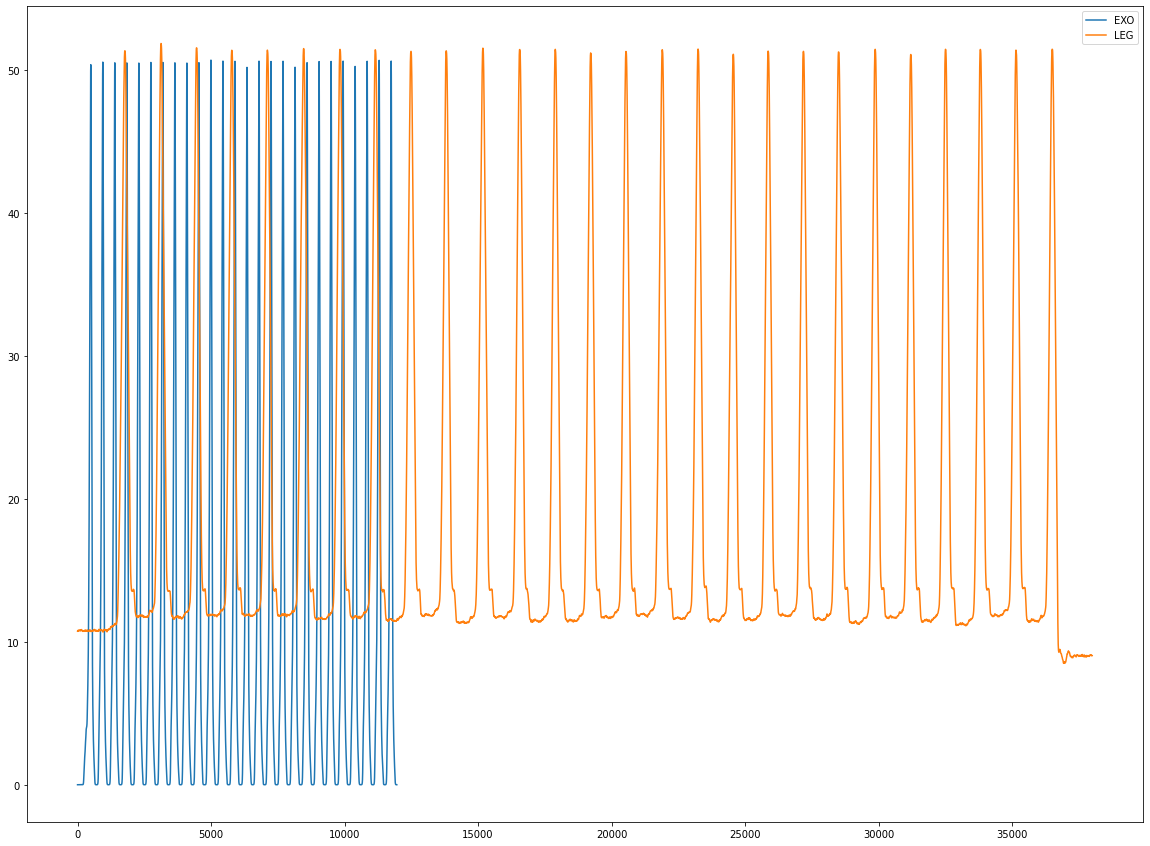

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(data_df[sheets[4]]['LKneePos'], label='EXO')
plt.plot(data_df[sheets[5]]['LegKneePositionFiltered'], label='LEG')
plt.legend()
plt.show()